In [1]:
import numpy as np
from keras.datasets import cifar10
from random import randrange
import time


/home/aminov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split

Подключим Tensorflow

In [3]:
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Визуализируем классы

In [6]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

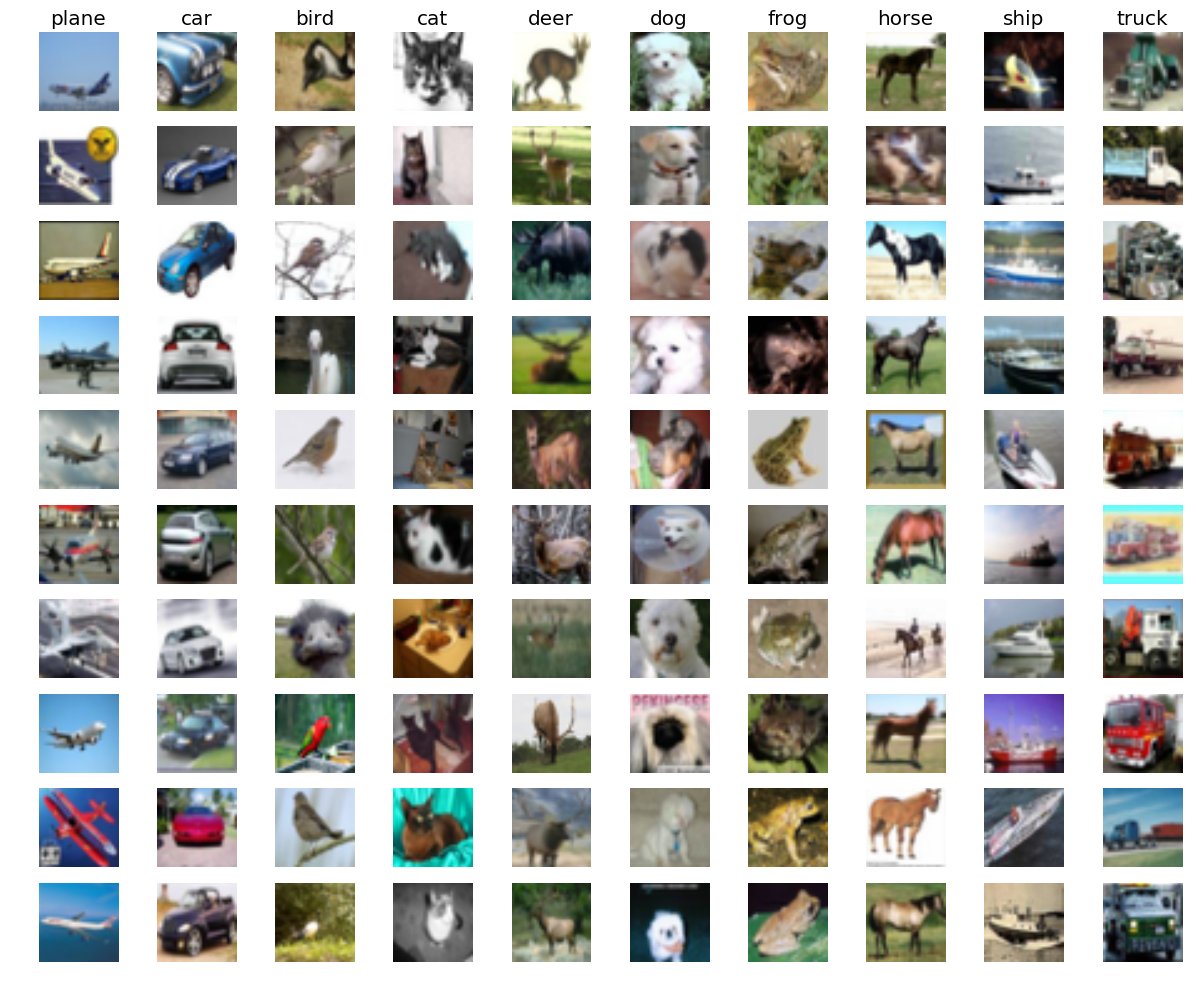

In [7]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

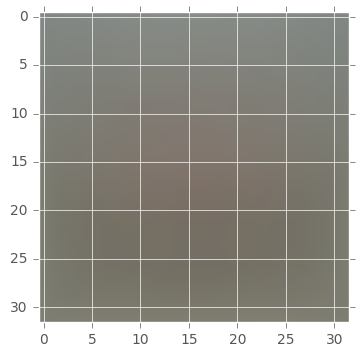

In [8]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [9]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image#x_train / 255 #
x_test = x_test - mean_image#x_test / 255 #

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

Попробуем решить задачу при помощи простой нейронной сети. Сначала объявим функцию, описывающую граф модели.

In [59]:
BN_EPSILON = 0.001
weight_decay = 0.0002

def create_variables(name, shape, initializer=tf.contrib.layers.xavier_initializer(), is_fc_layer=False):
    '''
    :param name: A string. The name of the new variable
    :param shape: A list of dimensions
    :param initializer: User Xavier as default.
    :param is_fc_layer: Want to create fc layer variable? May use different weight_decay for fc
    layers.
    :return: The created variable
    '''
    
    ## TODO: to allow different weight decay to fully connected layer and conv layer
    regularizer = tf.contrib.layers.l2_regularizer(scale=weight_decay)

    new_variables = tf.get_variable(name, shape=shape, initializer=initializer,
                                    regularizer=regularizer)
    return new_variables


def output_layer(input_layer, num_labels):
    '''
    :param input_layer: 2D tensor
    :param num_labels: int. How many output labels in total? (10 for cifar10 and 100 for cifar100)
    :return: output layer Y = WX + B
    '''
    input_dim = input_layer.get_shape().as_list()[-1]
    fc_w = create_variables(name='fc_weights', shape=[input_dim, num_labels], is_fc_layer=True,
                            initializer=tf.uniform_unit_scaling_initializer(factor=1.0))
    fc_b = create_variables(name='fc_bias', shape=[num_labels], initializer=tf.zeros_initializer())

    fc_h = tf.matmul(input_layer, fc_w) + fc_b
    return fc_h


def batch_normalization_layer(input_layer, dimension):
    '''
    Helper function to do batch normalziation
    :param input_layer: 4D tensor
    :param dimension: input_layer.get_shape().as_list()[-1]. The depth of the 4D tensor
    :return: the 4D tensor after being normalized
    '''
    mean, variance = tf.nn.moments(input_layer, axes=[0, 1, 2])
    beta = tf.get_variable('beta', dimension, tf.float32,
                               initializer=tf.constant_initializer(0.0, tf.float32))
    gamma = tf.get_variable('gamma', dimension, tf.float32,
                                initializer=tf.constant_initializer(1.0, tf.float32))
    bn_layer = tf.nn.batch_normalization(input_layer, mean, variance, beta, gamma, BN_EPSILON)

    return bn_layer


def conv_bn_relu_layer(input_layer, filter_shape, stride):
    '''
    A helper function to conv, batch normalize and relu the input tensor sequentially
    :param input_layer: 4D tensor
    :param filter_shape: list. [filter_height, filter_width, filter_depth, filter_number]
    :param stride: stride size for conv
    :return: 4D tensor. Y = Relu(batch_normalize(conv(X)))
    '''

    out_channel = filter_shape[-1]
    filter = create_variables(name='conv', shape=filter_shape)

    conv_layer = tf.nn.conv2d(input_layer, filter, strides=[1, stride, stride, 1], padding='SAME')
    bn_layer = batch_normalization_layer(conv_layer, out_channel)

    output = tf.nn.relu(bn_layer)
    return output


def bn_relu_conv_layer(input_layer, filter_shape, stride):
    '''
    A helper function to batch normalize, relu and conv the input layer sequentially
    :param input_layer: 4D tensor
    :param filter_shape: list. [filter_height, filter_width, filter_depth, filter_number]
    :param stride: stride size for conv
    :return: 4D tensor. Y = conv(Relu(batch_normalize(X)))
    '''

    in_channel = input_layer.get_shape().as_list()[-1]

    bn_layer = batch_normalization_layer(input_layer, in_channel)
    relu_layer = tf.nn.relu(bn_layer)

    filter = create_variables(name='conv', shape=filter_shape)
    conv_layer = tf.nn.conv2d(relu_layer, filter, strides=[1, stride, stride, 1], padding='SAME')
    print(conv_layer.shape)
    return conv_layer



def residual_block(input_layer, output_channel, first_block=False):
    '''
    Defines a residual block in ResNet
    :param input_layer: 4D tensor
    :param output_channel: int. return_tensor.get_shape().as_list()[-1] = output_channel
    :param first_block: if this is the first residual block of the whole network
    :return: 4D tensor.
    '''
    input_channel = input_layer.get_shape().as_list()[-1]

    # When it's time to "shrink" the image size, we use stride = 2
    if input_channel * 2 == output_channel:
        increase_dim = True
        stride = 2
    elif input_channel == output_channel:
        increase_dim = False
        stride = 1
    else:
        raise ValueError('Output and input channel does not match in residual blocks!!!')

    # The first conv layer of the first residual block does not need to be normalized and relu-ed.
    with tf.variable_scope('conv1_in_block'):
        if first_block:
            filter = create_variables(name='conv', shape=[3, 3, input_channel, output_channel])
            conv1 = tf.nn.conv2d(input_layer, filter=filter, strides=[1, 1, 1, 1], padding='SAME')
        else:
            conv1 = bn_relu_conv_layer(input_layer, [3, 3, input_channel, output_channel], stride)

    with tf.variable_scope('conv2_in_block'):
        conv2 = bn_relu_conv_layer(conv1, [3, 3, output_channel, output_channel], 1)

    # When the channels of input layer and conv2 does not match, we add zero pads to increase the
    #  depth of input layers
    if increase_dim is True:
        pooled_input = tf.nn.avg_pool(input_layer, ksize=[1, 2, 2, 1],
                                      strides=[1, 2, 2, 1], padding='VALID')
        padded_input = tf.pad(pooled_input, [[0, 0], [0, 0], [0, 0], [input_channel // 2,
                                                                     input_channel // 2]])
    else:
        padded_input = input_layer

    output = conv2 + padded_input
    return output
    
    
    
    
def build_simple_model(num_conv=20):
    # placeholder'ы это точки входа, можно восприпимать их, как аргументы функции, описываемой графом
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    
    layers = []
    with tf.variable_scope('conv0'):
        conv0 = conv_bn_relu_layer(x, [3, 3, 3, 16], 1)

        layers.append(conv0)
    
    n = 5
    
    for i in range(n):
        with tf.variable_scope('conv1_%d' %i):
            if i == 0:
                conv1 = residual_block(layers[-1], 16, first_block=True)
            else:
                conv1 = residual_block(layers[-1], 16)

            layers.append(conv1)

    for i in range(n):
        with tf.variable_scope('conv2_%d' %i):
            conv2 = residual_block(layers[-1], 32)
            layers.append(conv2)

    for i in range(n):
        with tf.variable_scope('conv3_%d' %i):
            conv3 = residual_block(layers[-1], 64)
            layers.append(conv3)
        assert conv3.get_shape().as_list()[1:] == [8, 8, 64]

#     for i in range(n):
#         with tf.variable_scope('conv4_%d' %i):
#             conv4 = residual_block(layers[-1], 128)
#             layers.append(conv4)
#         assert conv4.get_shape().as_list()[1:] == [4, 4, 128]
    
    with tf.variable_scope('fc'):
        in_channel = layers[-1].get_shape().as_list()[-1]
        bn_layer = batch_normalization_layer(layers[-1], in_channel)
        relu_layer = tf.nn.relu(bn_layer)
        global_pool = tf.reduce_mean(relu_layer, [1, 2])

        assert global_pool.get_shape().as_list()[-1:] == [64]
        output = output_layer(global_pool, 10)
        layers.append(output)

    y_out = layers[-1]
        
        
    # y_out -- это вектор оценок, которые генерирует модель. Теперь определим функцию потерь
    
    total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
#     total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    
    correct_prediction = tf.equal(tf.argmax(y_out,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Возвращаем те узлы графа, которые нам понадобятся в дальнейшем.
    #(x,y) это входы графа, а (y_out, mean_loss) выходы, которые представляют для нас интерес
    return (x,y), (y_out, mean_loss, accuracy)    
    
    

Написанная выше функция не осуществляет никаких вычислений, единственное её предназначение -- описание графа.

In [60]:
#Перед вызовом функции очистим память от графов других моделей (актуально если вы вызываете эту ячейку повторно)
tf.reset_default_graph()
(x,y), (y_out, mean_loss, accuracy) = build_simple_model()

batch = tf.Variable(0)

# learning_rate = tf.train.exponential_decay(
#   0.001,                # Base learning rate.
#   batch * 128,  # Current index into the dataset.
#   8,          # Decay step.
#   0.05,                # Decay rate.
#   staircase=True)

#Теперь зададим алгоритм оптимизации
optimizer = tf.train.AdamOptimizer(0.0002) #5e-5  0.001
#train_step -- специальный служебный узел в графе, отвечающий за обратный проход
train_step = optimizer.minimize(mean_loss) 

(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 32, 32, 16)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 16, 16, 32)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)


Пожалуйста, ознакомьтесь с другими возможностями, которые предоставляет tf для описания модели. 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/BatchNormalization

Теперь мы можем двигаться дальше и протестировать получившуюся модель. Для этого реализуем тренировочный цикл


In [61]:
def training_loop(session, model_inputs, model_outputs, train_step, epochs=10, batch_size=64):
    #создаём индекс по всем объектам
    index = np.arange(len(x_train))
    
    #перемешиваем его
    np.random.shuffle(index)
    
    #разбиваем на батчи
    num_batches = int(len(index) / batch_size)
    batch_indexes = np.array_split(index, num_batches)
    
    #аналогично для теста
    index_test = np.arange(len(x_test))
    np.random.shuffle(index_test)
    num_batches_test = int(len(index_test) / batch_size)
    batch_indexes_test = np.array_split(index_test, num_batches_test)
    
    #аналогично для validation
    index_val = np.arange(len(x_val))
    np.random.shuffle(index_val)
    num_batches_val = int(len(index_val) / batch_size)
    batch_indexes_val = np.array_split(index_val, num_batches_val)
    
    
    x,y = model_inputs
    y_out, mean_loss, accuracy = model_outputs
    
    def train(x_values, y_values, batch_indexes):
        train_loses = []
        for i, batch_index in enumerate(batch_indexes):

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index]}

            #Здесь происходит непоследственный вызов модели
            #Обратите внимание, что мы передаём train_step
            scores, loss, acc, _ = session.run([y_out, mean_loss, accuracy, train_step],feed_dict=feed_dict)

            train_loses.append(loss)
            print(f'iteration {i}, train loss: {loss:.3}, accuracy: {acc:.3}', end='\r')
        return train_loses
        
    def evaluate(x_values, y_values, batch_indexes):
        test_loses = []
        test_accuracy = []

        for batch_index in batch_indexes:

            #Создаём словарь, осуществляющий сопоставление входов графа (plaseholders) и значений
            feed_dict = {x: x_values[batch_index],
                         y: y_values[batch_index]}

            #Здесь происходит непоследственный вызов модели
            loss, acc = session.run([mean_loss, accuracy],feed_dict=feed_dict)

            test_loses.append(loss)
            test_accuracy.append(acc)

        return test_loses, test_accuracy
    
    # цикл по эпохам
    for e in range(epochs):
        print(f'Epoch {e}:')
        train_loses = train(x_train, y_train, batch_indexes)
        val_loses, val_accuracy = evaluate(x_val, y_val, batch_indexes_val)
        print(f'train loss: {np.mean(train_loses):.3}, val loss: {np.mean(val_loses):.3}, accuracy: {np.mean(val_accuracy):.3}')
      
    print('================================================')
    print('Test set results:')
    test_loses, test_accuracy = evaluate(x_test, y_test, batch_indexes_test)
    print(f'test loss: {np.mean(test_loses):.3}, accuracy: {np.mean(test_accuracy):.3}')

In [62]:
# создаём сессию. Сессия -- это среда, в которой выполняются вычисления
with tf.Session() as sess:
    #мы можем явно указать устройство
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        #инициализируем веса, в этот момент происходит выделение памяти
        sess.run(tf.global_variables_initializer())
        
        #запускаем тренировку
        training_loop(sess, model_inputs=(x,y),
                      model_outputs=(y_out, mean_loss, accuracy), 
                      train_step=train_step, epochs=300, batch_size=128)

Epoch 0:
train loss: 1.59, val loss: 1.29, accuracy: 0.534
Epoch 1:
train loss: 1.18, val loss: 1.09, accuracy: 0.606
Epoch 2:
train loss: 0.986, val loss: 0.974, accuracy: 0.653
Epoch 3:
train loss: 0.846, val loss: 0.931, accuracy: 0.673
Epoch 4:
train loss: 0.728, val loss: 0.925, accuracy: 0.684
Epoch 5:
train loss: 0.621, val loss: 0.977, accuracy: 0.667
Epoch 6:
train loss: 0.532, val loss: 1.01, accuracy: 0.676
Epoch 7:
train loss: 0.452, val loss: 1.05, accuracy: 0.671
Epoch 8:
train loss: 0.398, val loss: 1.08, accuracy: 0.671
Epoch 9:
train loss: 0.349, val loss: 1.07, accuracy: 0.692
Epoch 10:
train loss: 0.303, val loss: 1.12, accuracy: 0.679
Epoch 11:
train loss: 0.258, val loss: 1.27, accuracy: 0.665
Epoch 12:
train loss: 0.223, val loss: 1.3, accuracy: 0.665
Epoch 13:
train loss: 0.191, val loss: 1.33, accuracy: 0.674
Epoch 14:
train loss: 0.168, val loss: 1.31, accuracy: 0.664
Epoch 15:
train loss: 0.148, val loss: 1.34, accuracy: 0.681
Epoch 16:
train loss: 0.126, val 

train loss: 7.45e-05, val loss: 1.64, accuracy: 0.761
Epoch 133:
train loss: 6.42e-05, val loss: 1.64, accuracy: 0.761
Epoch 134:
train loss: 5.56e-05, val loss: 1.65, accuracy: 0.761
Epoch 135:
train loss: 4.83e-05, val loss: 1.66, accuracy: 0.761
Epoch 136:
train loss: 4.19e-05, val loss: 1.67, accuracy: 0.76
Epoch 137:
train loss: 3.63e-05, val loss: 1.68, accuracy: 0.757
Epoch 138:
train loss: 3.15e-05, val loss: 1.69, accuracy: 0.757
Epoch 139:
train loss: 2.72e-05, val loss: 1.7, accuracy: 0.757
Epoch 140:
train loss: 2.35e-05, val loss: 1.71, accuracy: 0.755
Epoch 141:
train loss: 2.02e-05, val loss: 1.72, accuracy: 0.756
Epoch 142:
train loss: 1.74e-05, val loss: 1.74, accuracy: 0.755
Epoch 143:
train loss: 1.49e-05, val loss: 1.75, accuracy: 0.755
Epoch 144:
train loss: 1.28e-05, val loss: 1.76, accuracy: 0.755
Epoch 145:
train loss: 1.09e-05, val loss: 1.78, accuracy: 0.754
Epoch 146:
train loss: 9.26e-06, val loss: 1.79, accuracy: 0.753
Epoch 147:
train loss: 7.87e-06, val l

Как видим, даже самая простая модель показывает очень неплохие результаты

**Задача 1:** Модифицируйте предыдущий код так, чтобы данные о тренировке (train\val loss) выводились в tensorboard. Изучите визуализацию графа модели.

**Задача 2 (основная)** Реализуйте сеть, подобную [VGG-16](https://arxiv.org/pdf/1409.1556.pdf) (или любую другую), для решения задачи. При реализации вам не разрешается пользоваться модулем **tf.layers** за исключением **tf.layers.batch_normalization** и **tf.layers.dropout**. Обратите внимание, что VGG-16 заточена под изображения большего разрешения.

Затем, после того, как сеть будет реализована постарайтесь получить масимально возможную точность, используя методы, описанные в лекциях (batch normalization, расписание learning rate, поменяйте функции активации, аугментация данных и т.д.). Результаты каждого слушателя затем будут занесены в таблицу и вывешены в репозитории курса.

Принимаются работы с точностью **не менее 84%**. 

Полезные ссылки:
  - [ResNet](https://arxiv.org/abs/1512.03385).
  - [DenseNet](https://arxiv.org/abs/1608.06993).
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

Напишите ваш код под текстом задания

## -------------------------------------------------------------------------------

In [169]:
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

def build_simple_model():
    # placeholder'ы это точки входа, можно восприпимать их, как аргументы функции, описываемой графом
    x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    
    #variable scope задаёт префикс для всех элементов внутри него
    #Это позволяет огранизовавывать структуру графа и вашего кода
    with tf.variable_scope("convolution_layer_1"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
        bconv1 = tf.get_variable("bconv1", shape=[32])
        
        a1 = tf.nn.conv2d(x, Wconv1, strides=[1,3,3,1], padding='SAME') + bconv1
        h1 = tf.nn.relu(a1)
#         h1 = maxpool2d(x, k=2)
        print('h1',h1.shape)
        
    with tf.variable_scope("convolution_layer_2"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv2 = tf.get_variable("Wconv2", shape=[7, 7, 32, 64])
        bconv2 = tf.get_variable("bconv2", shape=[64])
        
        a2 = tf.nn.conv2d(h1, Wconv2, strides=[1,3,3,1], padding='SAME') + bconv2
        h2 = tf.nn.relu(a2)
        print('h2',h2.shape)
    
    with tf.variable_scope("convolution_layer_3"):
        #создаём веса (W -- ядра свёрток, b -- сдвиг)
        Wconv3 = tf.get_variable("Wconv3", shape=[4, 4, 64, 128])
        bconv3 = tf.get_variable("bconv3", shape=[128])
        
        a3 = tf.nn.conv2d(h2, Wconv3, strides=[1,3,3,1], padding='SAME') + bconv3
        h3 = tf.nn.relu(a3)
        print('h3',h3.shape)
    
    #добавляем полносвязный слой
    with tf.variable_scope("dense_layer_1"):
        W1 = tf.get_variable("W1", shape=[4*128, 10])
        b1 = tf.get_variable("b1", shape=[10])
        
        h1_flat = tf.reshape(h3,[-1,4*128])
        y_out = tf.matmul(h1_flat,W1) + b1

        
    # y_out -- это вектор оценок, которые генерирует модель. Теперь определим функцию потерь
    
    total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
#     total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    
    correct_prediction = tf.equal(tf.argmax(y_out,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #Возвращаем те узлы графа, которые нам понадобятся в дальнейшем.
    #(x,y) это входы графа, а (y_out, mean_loss) выходы, которые представляют для нас интерес
    return (x,y), (y_out, mean_loss, accuracy)